# Artificial Neural Networks and Deep Learning

---

## Homework 1

The following is a notebook containing the code for the final model we submitted, along with some code used in previous models for reference. It is meant to be run locally, but can be run on Google Colab by uncommenting some lines, if usage limits allow for it. The code takes about 3 hours to run to completion on an old system with an RTX 2060 Mobile, an AMD Ryzen 7 3750H and 16 GB of RAM.


## 🌐 Connect Colab to Google Drive

In [1]:
# For Colab only.
#from google.colab import drive

#drive.mount('/gdrive')
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [ ]:
# Fix library versions (only on the first installation).
# This is needed because the code sometimes breaks if the libraries are
# installed outside the VSCode environment. Furthermore, some libraries
# need to be downgraded to match the same version as Google Colab and 
# Codabench, and KerasCV breaks if installed after Keras.
#!python3 -m pip uninstall tensorflow -y
#!python3 -m pip uninstall keras -y
#!python3 -m pip uninstall keras-cv -y
#!python3 -m pip install keras-cv
#!python3 -m pip install tensorflow==2.17.0
#!python3 -m pip install keras==3.4.1

In [ ]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_cv.layers

# Seed-setting is done as a means to ensure reproducibility. Being able to 
# reproduce the results is crucial for debugging and verifying the correctness
# of the code.
seed = 11037
np.random.seed(seed)
tf.random.set_seed(seed)

import random
random.seed(seed)

2024-11-22 17:27:16.803609: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 17:27:16.851106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 17:27:16.866791: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 17:27:16.997223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-22 17:27:19.482745: W tensorflow/compiler/tf2

## ⏳ Load the Data

In [ ]:
# Read training_set.npz to get the dataframe.
data = np.load('training_set.npz', allow_pickle=True)

# Up to the 11958th image, everything seems to be normal. In intervals from
# 11959 to 13558 and from 13559 to 13758, the images have been overlaid with
# irrelevant images. These images are not relevant to the classification task
# and should be ignored.
images = data['images'][:11959]
labels = data['labels'][:11959]

In [ ]:
# Images are stored as 96x96x3 numpy arrays.
print("Shape of all images:")
print(images[0].shape)

# Count the images.
print()
print("Total number of images: ")
total_num_images = images.shape[0]
print(total_num_images)

# Count the amount of images with a given label. We do this to see if the
# dataset is balanced, which it isn't. Some labels contain more images than
# others, relative to the total number of images.
print()
print("Number of images with a given label:")
for n, elm in enumerate(np.unique(labels, return_counts=True)[-1]):
    print(f"Label {n}: {elm} ({np.round(elm/total_num_images*100, 1)}%)")

Shape of all images:
(96, 96, 3)

Total number of images: 
11959

Number of images with a given label:
Label 0: 852 (7.1%)
Label 1: 2181 (18.2%)
Label 2: 1085 (9.1%)
Label 3: 2026 (16.9%)
Label 4: 849 (7.1%)
Label 5: 993 (8.3%)
Label 6: 2330 (19.5%)
Label 7: 1643 (13.7%)


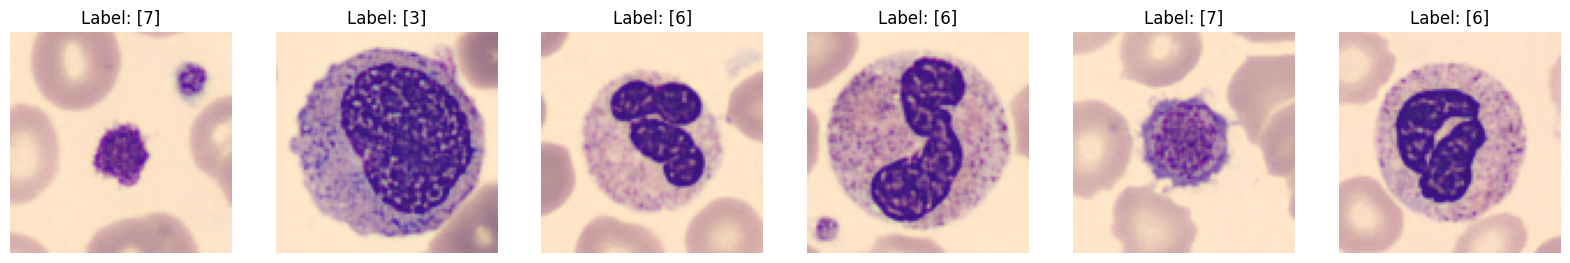

In [ ]:
# Display the first few images with matplotlib, in order to figure out what
# the images look like, and whether or not they contain any irrelevant data.
plotted_images = 6
fig, axs = plt.subplots(1, plotted_images, figsize=(20, 20))

for i in range(plotted_images):
    axs[i].imshow(images[i])
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')

plt.show()


## Split in train, validation and test sets

In [ ]:
from sklearn.model_selection import train_test_split

# Split the training and validation sets. We use 80% of the data for training
# and 20% for validation. The stratify parameter is used to ensure that the
# distribution of labels is the same in both sets.
X_train, X_val, y_train, y_val = train_test_split(
    images,
    labels,
    test_size=0.2,
    random_state=seed,
    stratify=labels
)

# Print the shapes of the resulting sets. This is done to ensure that the
# splitting was correctly applied to the data.
print('Overall shape:\t\t', images.shape, labels.shape)
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)

Overall shape:		 (11959, 96, 96, 3) (11959, 1)
Training set shape:	 (9567, 96, 96, 3) (9567, 1)
Validation set shape:	 (2392, 96, 96, 3) (2392, 1)


## Process data

### Normalize data and encode labels

In [ ]:
# Normalize data to the range [0, 1].
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')

# Print the first few pixel values of the first image, to verify that the
# normalization was successful. These values correspond to the RGB values of
# the first pixel in the first image, and they should range from 0 to 1.
print('First image pixel values:')
print(X_train[0, 0, 0, :])

# Convert labels to categorical format using one-hot encoding.
# We need to convert the labels to a categorical format, since the model 
# will output a probability distribution over the classes.
# To do this, we use one-hot encoding.
y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

First image pixel values:
[0.8156863  0.67058825 0.6666667 ]


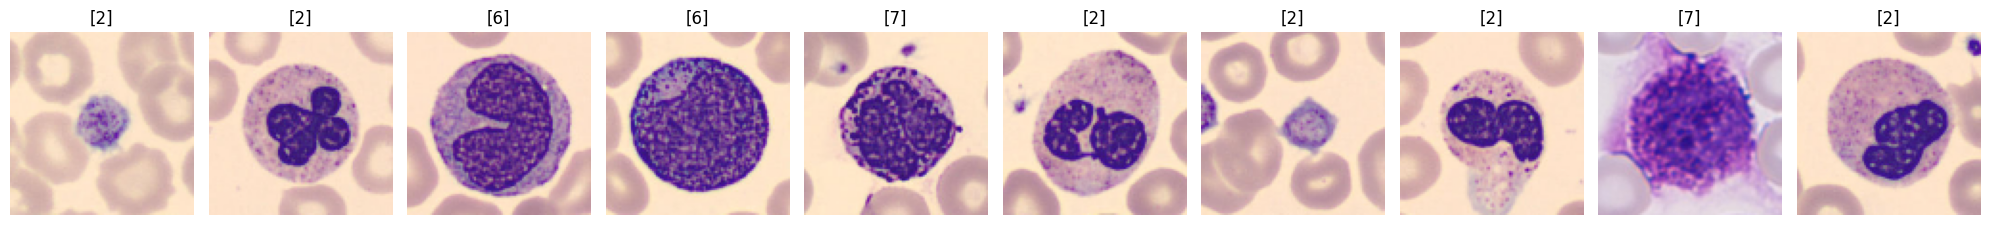

In [ ]:
# Display a sample of images from the dataset. This sample is randomly selected
# from the training set. The images are displayed with their corresponding
# labels. Once again, this is done to ensure that the data is correctly
# preprocessed. We can't know whether or not the labels are correct, since we
# can't differentiate between blood cell types, but we can at least verify that
# images with the same label look similar, and get an idea of the type of
# images we are working with.
set_to_sample = X_train
labels_to_sample = y_train
num_img = 10
random_indices = random.sample(range(len(set_to_sample)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images.
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(set_to_sample[idx]), vmin=0., vmax=1.)
    ax.set_title(str(data['labels'][np.argmax(labels_to_sample[idx])]))
    ax.axis('off')

# Adjust layout and display the images.
plt.tight_layout()
plt.show()

## 💪 Image Augmentation

I0000 00:00:1732292855.548629  239810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732292855.758666  239810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732292855.760552  239810 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1732292855.766269  239810 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

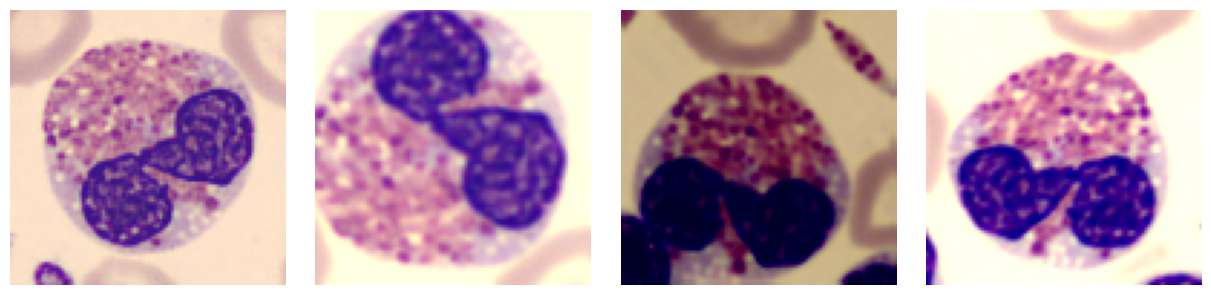

In [ ]:
import matplotlib.gridspec as gridspec
img = X_train[0]

# Define a sequential model for image augmentation. This particular model
# applies a series of random transformations to the input image, but isn't
# used for training. It's only used to visualize the effects of the
# transformations, in order to verify that they work as intended.
augmentation = tf.keras.Sequential([
    # A number of transformations are applied to the image.
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),

    # Lastly, we chose to apply some color transformations to the image,
    # namely brightness and contrast adjustments.
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='preprocessing')

# Set up the figure and grid layout for displaying images.
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image. This is the image that will be augmented, and
# the following images will be the result of the augmentation.
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image.
augmented_img = np.clip(augmentation(img)._numpy().astype('float32'), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image.
augmented_img = np.clip(augmentation(img)._numpy().astype('float32'), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image.
augmented_img = np.clip(augmentation(img)._numpy().astype('float32'), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images.
plt.show()

In [ ]:
# Create a function to apply overlays (convex combination of the images).
# Overlays are used to create new images by combining two images in a
# weighted manner. The function takes an image, an overlay image, and a
# weight, and returns the resulting image. The weight determines how much
# of the overlay image will be visible in the final image. The idea behind
# this function started by looking through the doctored images in the
# training set, and hypothesizing that the test set would contain similar
# images. Overlaying is not used during training, but was used in older
# models.
def overlay(image, overlay_name, alpha):
    # Load the images.
    image_overlay = tfk.preprocessing.image.load_img(overlay_name)
    image_overlay = tfk.preprocessing.image.img_to_array(image_overlay).astype('uint8')
    image_original = image

    # Add the images' weighted pixels.
    image_result = alpha*image_overlay + (1-alpha)*image_original
    image_result = image_result.astype('uint8')

    return image_result

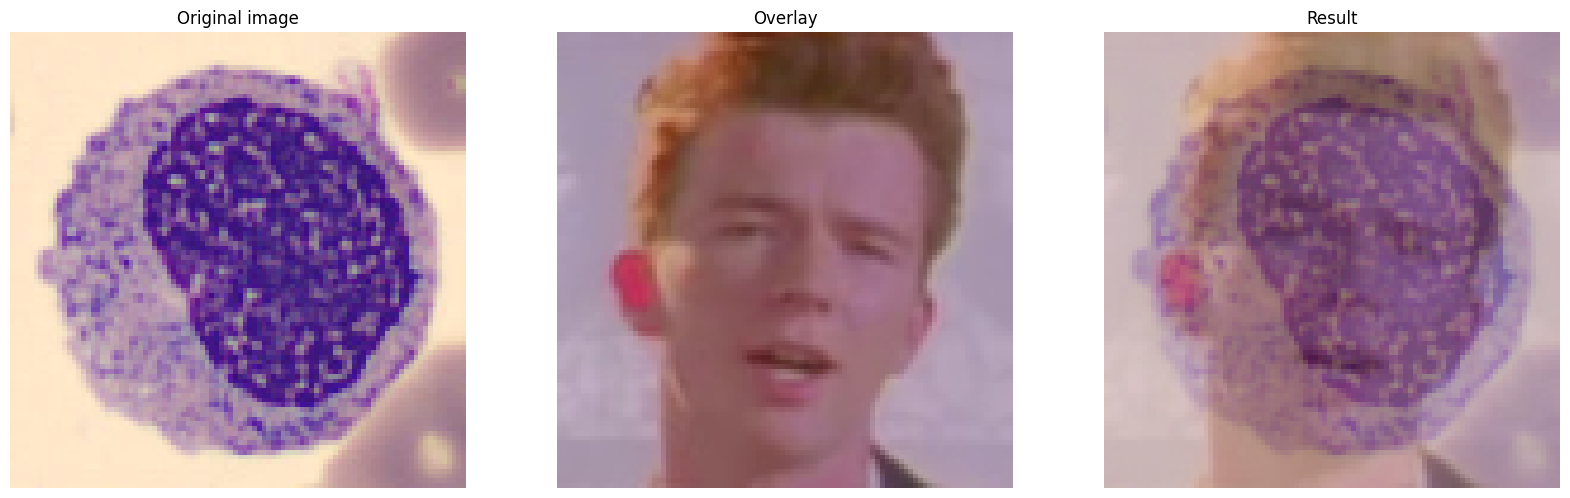

In [19]:
# Pick a random image from the dataset and an overlay.
overlay_filename = "overlay.png"
image_overlay = tfk.preprocessing.image.load_img(overlay_filename)
image_overlay = tfk.preprocessing.image.img_to_array(image_overlay).astype('uint8')
image_original = images[1]

# Display the images.
fig, axs = plt.subplots(1, 3, figsize=(20, 20))

axs[0].imshow(image_original)
axs[0].set_title("Original image")
axs[0].axis('off')

axs[1].imshow(image_overlay)
axs[1].set_title("Overlay")
axs[1].axis('off')

# Compute the overlay.
image_result = overlay(image_original, overlay_filename, 0.6)

# Display the result.
axs[2].imshow(image_result)
axs[2].set_title("Result")
axs[2].axis('off')

plt.show()


In [ ]:
# Create a preprocessing pipeline with augmentations.
batch_size = 128
num_classes = 8
augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(seed=seed),
        keras_cv.layers.RandAugment(value_range=(0, 1),seed=seed),
        keras_cv.layers.CutMix(seed=seed),
        #keras_cv.layers.AugMix(value_range=(0, 1),seed=seed),
    ],
)

def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

# Augment the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(batch_size).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

# Augment the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(batch_size).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

2024-11-22 11:02:03.138714: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1058033664 exceeds 10% of free system memory.
2024-11-22 11:02:05.025797: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1058033664 exceeds 10% of free system memory.
2024-11-22 11:02:12.760307: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264536064 exceeds 10% of free system memory.
2024-11-22 11:02:13.276939: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 264536064 exceeds 10% of free system memory.


## 🧮 Define Network Parameters

In [ ]:
# Input shape for the model. If everything is set up correctly, the input
# shape should be a 96x96x3 tensor, which corresponds to the shape of the
# images in the dataset, and the depth of their channels.
input_shape = train_dataset.element_spec[0].shape[1:]

# Output shape for the model. The output shape should be 8, as there are 8
# classes in the dataset. This is the shape of the one-hot encoded labels.
output_shape = train_dataset.element_spec[1].shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
# Number of training epochs. Note that this number can be relatively high,
# as the model uses early stopping to prevent overfitting. The model will
# stop training when the validation loss stops decreasing.
epochs = 1000

# Batch size for training.
batch_size = 128

# Learning rate: step size for updating the model's weights.
learning_rate = 0.001

# Print the defined parameters.
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 1000
Batch Size: 128
Learning Rate: 0.001


## 🛠️ Build the Model

In [ ]:
# Define a Residual block with configurable parameters (currently unused, but
# used in older models). Note that a modified version of this block is used in
# the final model, by combining it with the inception block.
def residual_block(x, filters, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # First convolutional block with Batch Normalisation and activation.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block.
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [ ]:
# Define the Inception block with batch normalization (BN) and with multiple
# convolution paths and optional downsampling.
def inception_block_bn(x, filters, padding='same',
                       downsample=True, activation='relu', stack=2, name='inception'):
    # This inception block consists of a 1x1 convolution path, a 3x3 convolution
    # path, a 5x5 convolution path, and a pooling path. The paths are then
    # concatenated to form the final block output.
    # The reason for using multiple paths is to allow the model to learn
    # different features at different scales, and to increase the model's
    # capacity without increasing the number of parameters too much.
    # The downsampling (pooling) is not mandatory.

    # Loop through specified stack layers for multiple inception paths.
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation.
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer.
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer.
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction.
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output.
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [ ]:
# Define the a residual block using an inception block instead of the 
# convolutional path. This mixed block is used in the final model, and it
# combines the benefits of both residual and inception blocks. We believe
# that the residual and inception blocks are complementary, as their guesses
# don't seem to perfectly overlap. See the report for more details.
def inception_residual(x, filters, padding='same', downsample=True, 
                       activation='relu', stack=2, inception_stack=2,
                       name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # Create the inception block.
        x = inception_block_bn(x, filters, padding, downsample=False, activation=activation,
                               stack=inception_stack, name=f'{name}_inception_{s}')

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling.
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [ ]:
def build_model(
    input_shape=input_shape,        # Input shape for the model.
    output_shape=output_shape,      # Output shape for the model.
    learning_rate=learning_rate,    # Learning rate for the optimizer.
    augmentation=None,              # Optional data augmentation.
    seed=seed                       # Random seed for reproducibility.
):
    # Set the random seed for reproducibility.
    tf.random.set_seed(seed)

    # Define the input layer.
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # From here on, we denote the output of each layer as `x`, and we will
    # build the model by successively adding layers to it by reassigning it.

    # Apply optional data augmentation.
    if augmentation == None:
        # If no Keras augmentation is specified, we use the input layer as is.
        x = input_layer
    else:
        x = augmentation(input_layer)

    # Apply first convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=60, kernel_size=3, padding='same', name='conv0')(x)
    x = tfkl.BatchNormalization(name='norm0')(x)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=120, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.BatchNormalization(name='norm1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Add two residual blocks.
    x = inception_residual(x, filters=240, downsample=True, stack=2, inception_stack=2, name='res1')

    # Add two more residual blocks.
    x = inception_residual(x, filters=480, downsample=True, stack=2, inception_stack=2, name='res2')

    # Apply global average pooling.
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Add a dense layer with activation.
    x = tfkl.Dense(units=128, name='dense1')(x)
    x = tfkl.ReLU(name='relu5')(x)
    # Add a dropout layer to prevent overfitting.
    x = tfkl.Dropout(rate=0.6, name='dropout')(x)

    # Define the output layer with softmax activation for classification.
    x = tfkl.Dense(units=output_shape, name='dense2')(x)
    output_layer = tfkl.Activation('softmax', name='softmax')(x)

    # Create the model.
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model with categorical crossentropy loss and Adam optimizer.
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model.
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Input             │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv0 (Conv2D)    │ (None, 96, 96,  │     1,680 │ Input[0][0]    │   Y   │
│                   │ 60)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ norm0             │ (None, 96, 96,  │       240 │ conv0[0][0]    │   Y   │
│ (BatchNormalizat… │ 60)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ relu0 (ReLU)      │ (None, 96, 96,  │         0 │ norm0[0][0]    │   -   │
│                   │ 60)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ mp0               │ (None, 48, 48,  │         0 │ relu0[0][0]    │   -   │
│ (MaxPooling2D)    │ 60)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1 (Conv2D)    │ (None, 48, 48,  │    64,920 │ mp0[0][0]      │   Y   │
│                   │ 120)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ norm1             │ (None, 48, 48,  │       480 │ conv1[0][0]    │   Y   │
│ (BatchNormalizat… │ 120)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ relu1 (ReLU)      │ (None, 48, 48,  │         0 │ norm1[0][0]    │   -   │
│                   │ 120)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ mp1               │ (None, 24, 24,  │         0 │ relu1[0][0]    │   -   │
│ (MaxPooling2D)    │ 120)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │     3,630 │ mp1[0][0]      │   Y   │
│ (Conv2D)          │ 30)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │     2,420 │ mp1[0][0]      │   Y   │
│ (Conv2D)          │ 20)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │       120 │ res1_inceptio… │   Y   │
│ (BatchNormalizat… │ 30)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │        80 │ res1_inceptio… │   Y   │
│ (BatchNormalizat… │ 20)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │         0 │ res1_inceptio… │   -   │
│ (Activation)      │ 30)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │         0 │ res1_inceptio… │   -   │
│ (Activation)      │ 20)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │         0 │ mp1[0][0]      │   -   │
│ (MaxPooling2D)    │ 120)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │     7,260 │ mp1[0][0]      │   Y 

 Total params: 1,932,920 (7.37 MB)

 Trainable params: 1,924,160 (7.34 MB)

 Non-trainable params: 8,760 (34.22 KB)

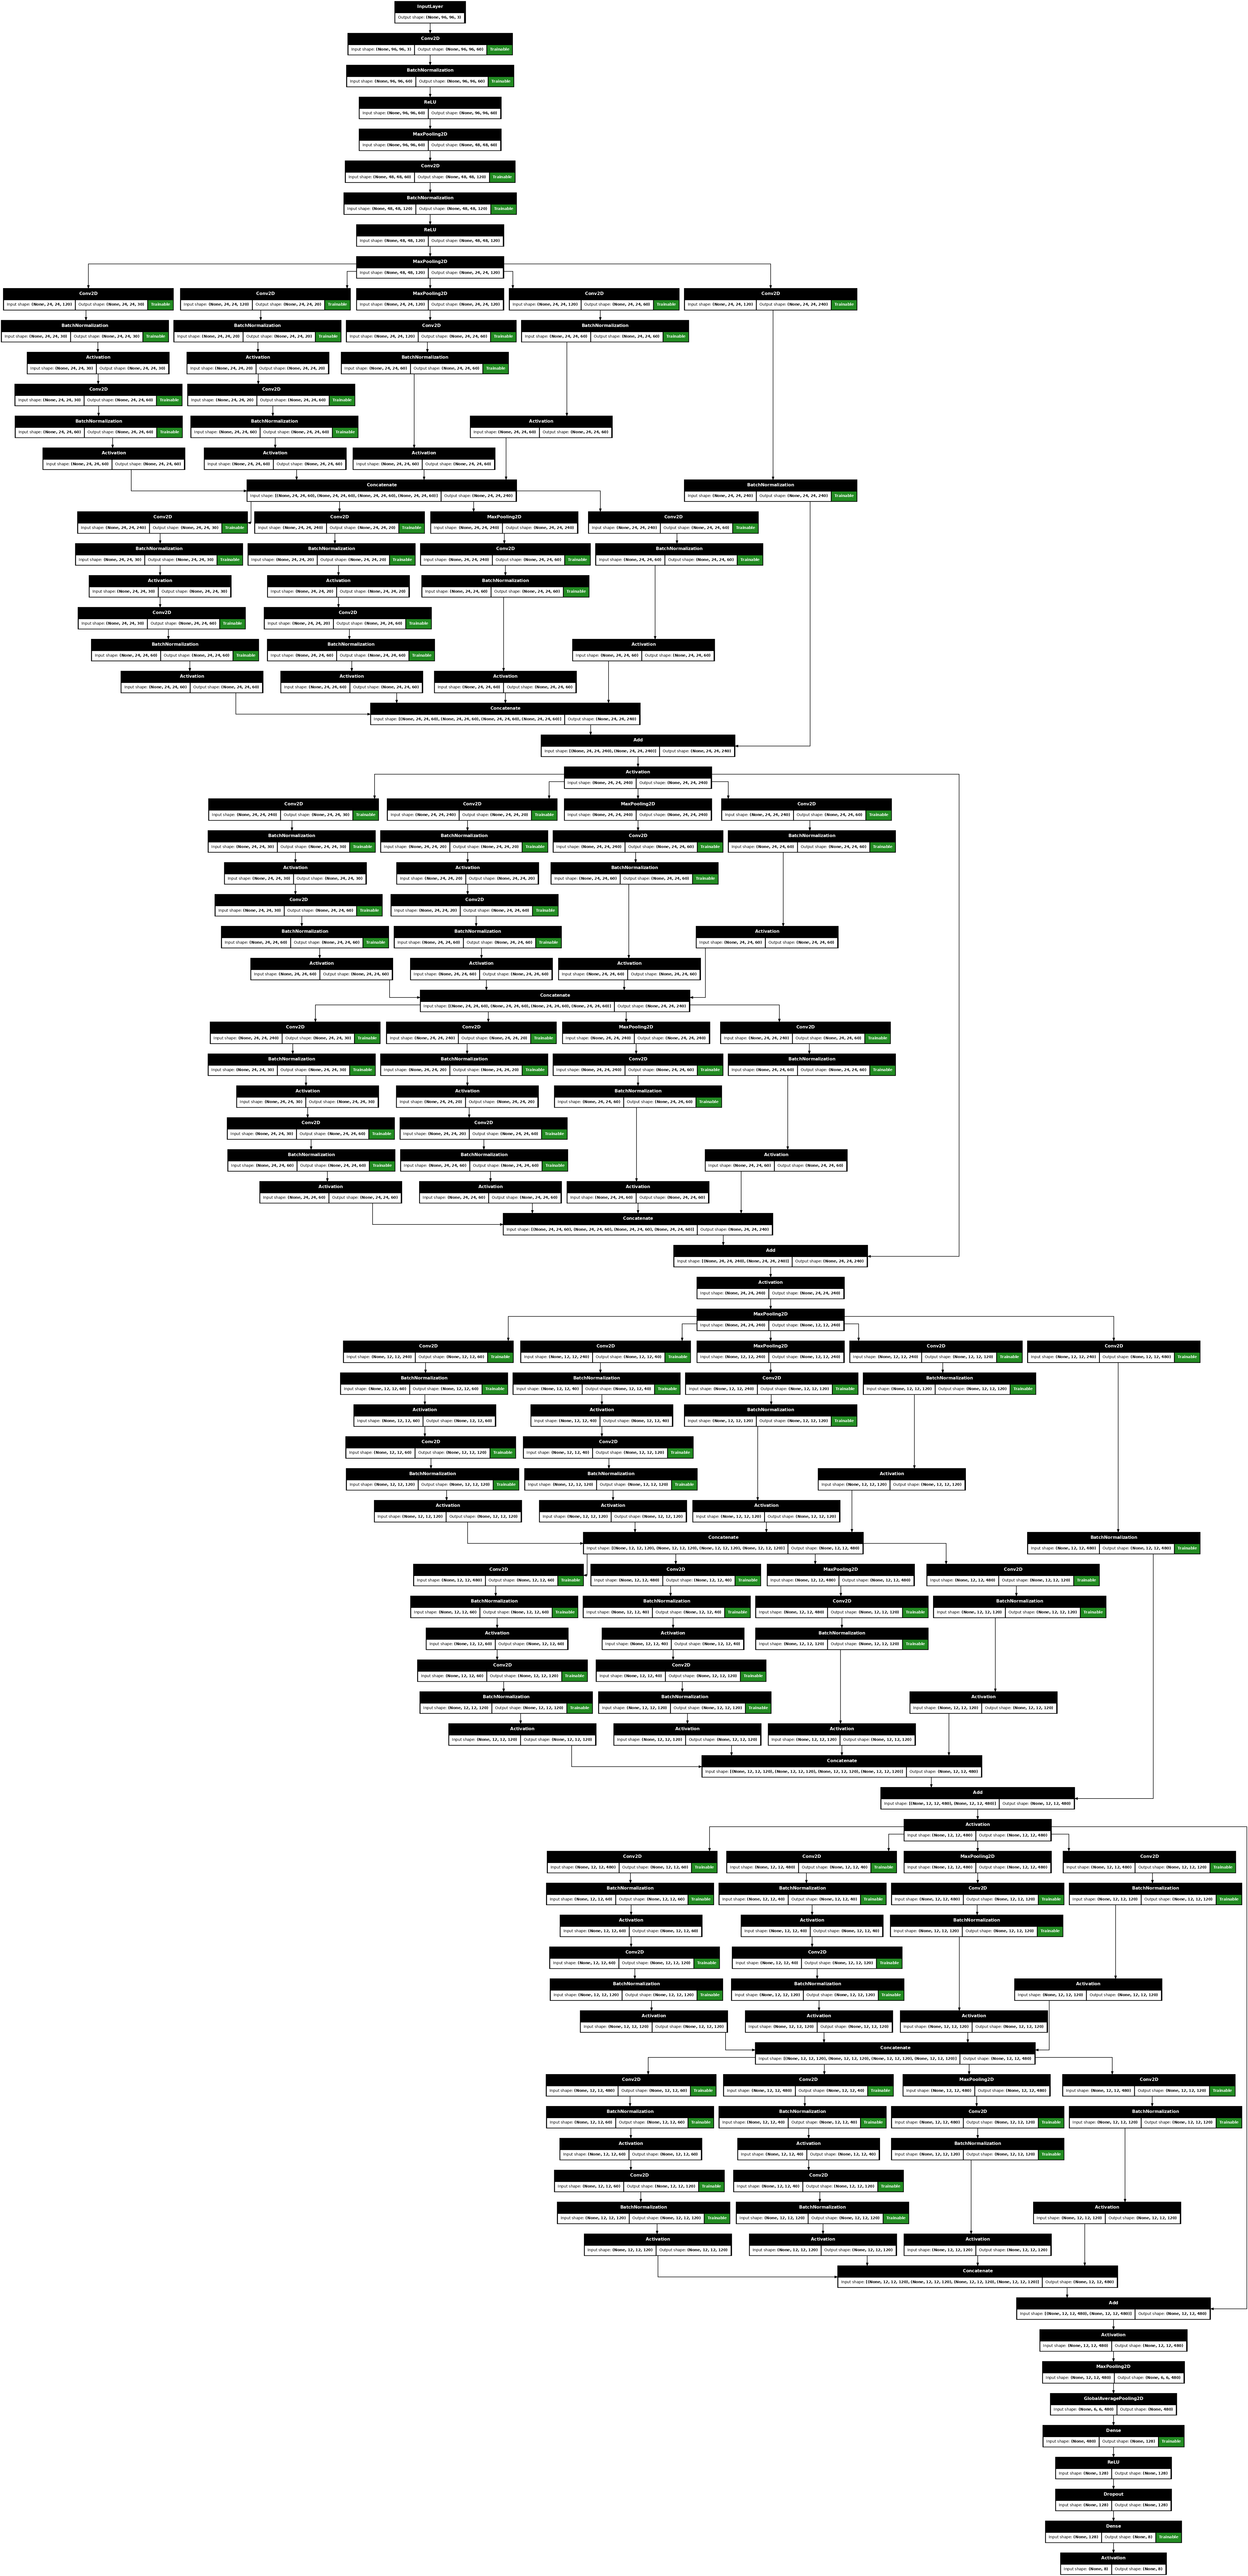

In [ ]:
# Build the model with specified input and output shapes.
# No standard Keras augmentation is used, while Keras CV is used.
model = build_model(augmentation=None)

# Display a summary of the model architecture.
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture.
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [ ]:
# Define the patience value for early stopping.
patience = 40

# Create an EarlyStopping callback. This callback is used to stop the training
# process when the model's performance on the validation set decreases.
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=patience//2
)

checkpoint = tfk.callbacks.ModelCheckpoint(
    '{epoch:02d}-{val_loss:.2f}.keras', 
    save_freq="epoch"
) 

# Store the callback in a list, that we will feed to the model.fit function.
callbacks = [early_stopping, reduce_lr, checkpoint]

In [ ]:
# Train the model with early stopping callback. Please note that this cell
# can take a long time to run, depending on your hardware. The model will
# stop training when the validation loss stops decreasing for enough epochs.
history = model.fit(
    train_dataset,                  # Training data.
    batch_size=batch_size,          # Batch size.
    epochs=epochs,                  # Number of epochs.
    validation_data=val_dataset,    # Validation
    callbacks=callbacks             # Early stopping.
).history

# Calculate and print the final validation accuracy.
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename.
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources.
del model

Epoch 1/1000


2024-11-15 18:41:36.592232: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1058033664 exceeds 10% of free system memory.
I0000 00:00:1731692541.825309  394832 service.cc:146] XLA service 0x78f870129f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731692541.825407  394832 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-11-15 18:42:23.583804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-15 18:42:29.296988: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1731692581.557558  394832 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.1861 - loss: 2.5297 - val_accuracy: 0.1480 - val_loss: 2.4649 - learning_rate: 0.0010
Epoch 2/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 45s 558ms/step - accuracy: 0.2217 - loss: 1.9886 - val_accuracy: 0.1329 - val_loss: 2.2086 - learning_rate: 0.0010
Epoch 3/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 580ms/step - accuracy: 0.2636 - loss: 1.9343 - val_accuracy: 0.1334 - val_loss: 2.4624 - learning_rate: 0.0010
Epoch 4/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 573ms/step - accuracy: 0.2960 - loss: 1.8990 - val_accuracy: 0.1359 - val_loss: 2.6012 - learning_rate: 0.0010
Epoch 5/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 47s 578ms/step - accuracy: 0.3128 - loss: 1.8610 - val_accuracy: 0.1484 - val_loss: 2.1629 - learning_rate: 0.0010
Epoch 6/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 49s 602ms/step - accuracy: 0.3471 - loss: 1.8164 - val_accuracy: 0.2956 - val_loss: 1.9126 - learning_rate: 0.0010
Epoch 7/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 50s 606ms/step - accuracy: 0.3498 - loss: 1.8

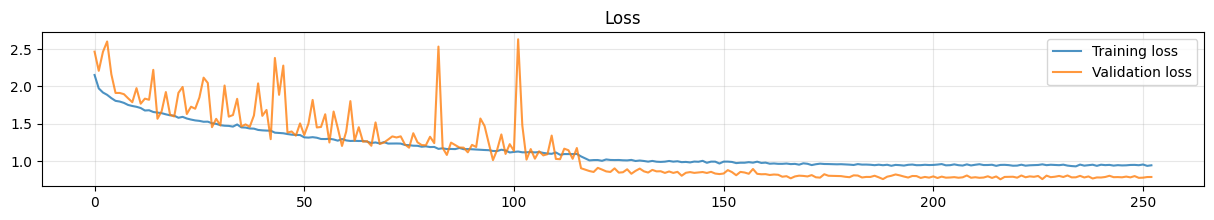

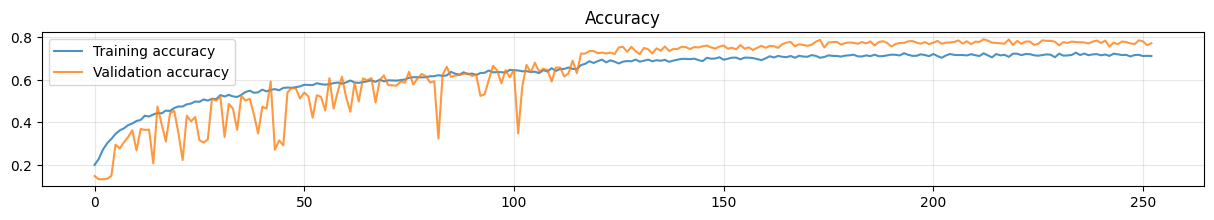

In [21]:
# Plot training and validation loss.
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy.
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 📊 Prepare the Submission

The submission is a `.zip` file that includes all the necessary code to run the model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell creates the file.

In [22]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        # Load the CNN.
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        # Map X to [0,1].
        X_normalized = (X / 255).astype('float32')

        # Predict.
        preds = self.neural_network.predict(X_normalized)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Create the submission.
!zip {filename} model.py weights.keras

# Download the submission (Colab only).
#from google.colab import files
#files.download(filename)

  adding: model.py (deflated 48%)
  adding: weights.keras (deflated 11%)


## 🕹️ Test the Model

This section is used to check if the model is working. However, it does not give any information on the model's accuracy on Codabench, which uses a completely different dataset. The final accuracy on Codabench was 0.88 in both phases. The accuracy on the training set is lower than on the validation set due to the Dropout layer, and the accuracy on the validation set is lower than the one on Codabench due to the very aggressive augmentation used in training and valitation. Clearly, the accuracy on the validation set with no augmentation is much higher than the one on Codabench. No local test set is used due to results being almost uncorrelated to the accuracy on Codabench.

In [ ]:
# Import the Model class to test if everything works.
import importlib
import model
importlib.reload(model)
model_object = model.Model()

75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step
Accuracy score over the test set: 0.9866
Precision score over the test set: 0.9868
Recall score over the test set: 0.9866
F1 score over the test set: 0.9866


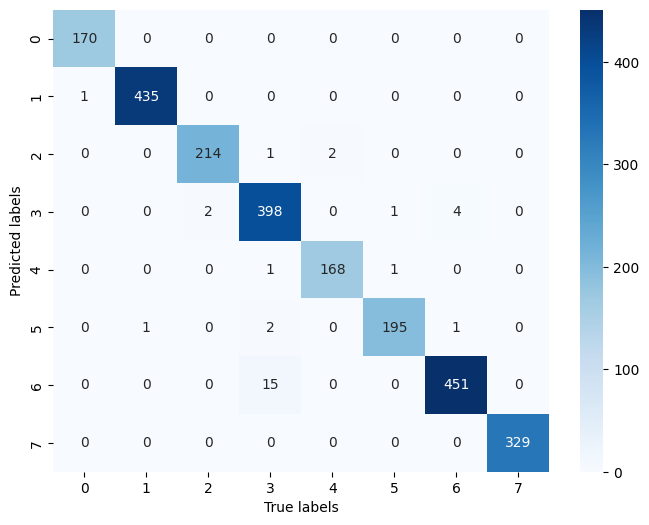

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Predict class probabilities and get predicted classes on the validation set.
test_predictions = model_object.predict(X_val * 255)

# Extract ground truth classes.
test_gt = np.argmax(y_val, axis=1)

# Calculate and display test set accuracy.
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision.
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall.
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score.
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix.
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values.
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(8), yticklabels=range(8), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()